<a href="https://colab.research.google.com/github/dkgithub/wiehl24/blob/main/autograd_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%matplotlib inline


Autograd: Automatic Differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with `requires_grad=True`,
but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



In [ ]:
import torch

Create a tensor and set **requires_grad=True** to track computation with it



In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do an operation of tensor, e.g. add a number:



In [ ]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [ ]:
print(y.grad_fn)

Do more operations on y



In [ ]:
z = y * y * 3
out = z.mean()
q=x**2
print(z, out)
print(q, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
tensor([[1., 1.],
        [1., 1.]], grad_fn=<PowBackward0>) tensor(27., grad_fn=<MeanBackward0>)


``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given. This allows us to calculate a tensor and then start tracking the operations for grading calculation.



In [ ]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


### We use a little tool to draw the list of operation, i.e. the computation graph

https://github.com/szagoruyko/pytorchviz

It produces Graphviz representation of PyTorch autograd graph.
* Blue nodes are the Variables that require grad,
* orange are Tensors saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that require grad


In [11]:
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-pwvlk1d7
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-pwvlk1d7
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4973 sha256=d44e9adc99f590f10617af86d6c8ddbf259a3c3af6a2caa9f54a4f550085704b
  Stored in directory: /tmp/pip-ephem-wheel-cache-oiifofsa/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


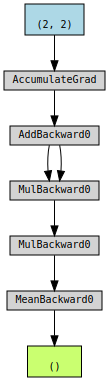

In [13]:
from torchviz import make_dot
# we neglect the parameter here which defines the names
# the tool is meant for ploting models
make_dot(out)

Gradients
---------
Let's backprop now
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1))``.



In [14]:
out.backward()

The calculated gradients are available as member of the tensor.  Here, **x.grad**.

print gradients d(out)/dx




In [15]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


After you had (above [4]-[7]) executed
```python
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()
q=x**2
```
You should have got a 2x2 matrix of ``4.5``.

Let’s call the ``out``
*Tensor* “$o$”.

We follow the calculations backwards to calculate the derivative.

We have (mean)
$o = \frac{1}{4}\sum_i z_i$,

$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.

Therefore,
$\frac{\partial o}{\partial x_i} =
\frac{\partial o}{\partial z_i} \frac{\partial z_i}{\partial x_i} =
\frac{3}{2}(x_i+2)$, hence

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.



<hr>
Another simple example
$L=\sum_{i=0}^4 a_i^2$

$\frac{dL}{d\vec{\,a}}=grad(L)=2\vec{\,a}$

In [17]:
a=torch.tensor([1.,2.,3.,4.,5.],requires_grad=True)
L=torch.sum(a*a)
L.backward()
print(L)
print(a.grad)

tensor(55., grad_fn=<SumBackward0>)
tensor([ 2.,  4.,  6.,  8., 10.])


<hr>
You can do many crazy things with autograd!

What you run as python code is what you differentiate.



tensor([ 2.2155, -0.3304,  1.9977], requires_grad=True)
tensor(1536.7172, grad_fn=<LinalgVectorNormBackward0>)


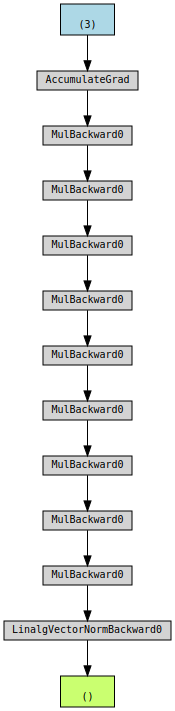

In [20]:
x = torch.randn(3, requires_grad=True)
print(x)
y = x * 2
while y.data.norm() < 1000:
    y = y * 2
y=y.norm()
print(y)
make_dot(y)

In [21]:
y.backward()
print(x.grad)

tensor([377.9416, -56.3699, 340.7736])


You can also stop autograd from tracking history on Tensors
with ``.requires_grad``=True by wrapping the code block in
``with torch.no_grad():``



In [22]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
	print((x ** 2).requires_grad)

True
True
False


**Read Later:**

Documentation of ``autograd`` and ``Function`` is at
http://pytorch.org/docs/autograd

The argument of the backward method is multiplied with the final gradient.
Typically, we just leave it empty but it can be used to manipulate gradients.

In [36]:
A=torch.tensor([[1.,2.],[3.,4.]],requires_grad=True)
print('A',A)
# matrix multiplication
B=torch.mm(A,A)
print('B',B)
l=B[0,0]
l.backward()
# l is 1-dim
# By the rules of matrix mult.
# B[0,0] depends on A[0,0],A[1,0] and A[0,1] but not on A[1,1]
# therefor A.grad[1,1] is zero
print(A.grad)

A tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
B tensor([[ 7., 10.],
        [15., 22.]], grad_fn=<MmBackward0>)
tensor([[2., 3.],
        [2., 0.]])


In [40]:
# the same but for l.shape=(2,2)
A=torch.tensor([[1.,2.],[3.,4.]],requires_grad=True)
print('\nA',A)
B=torch.mm(A,A)
print('B',B)
l=B
# now l is not a scalar but a 2x2 tensor
# the chain of derivatives is multiplied with the backward argument
# This allows to combine derivative calculations etc. or here to select some gradient
# l.backward() would give: RuntimeError: grad can be implicitly created only for scalar outputs
l.backward(torch.tensor([[1.,0],[0,0]]))
print(A.grad)


A tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
B tensor([[ 7., 10.],
        [15., 22.]], grad_fn=<MmBackward0>)
tensor([[2., 3.],
        [2., 0.]])


In [37]:
# the same but for l.shape=(2,2)
A=torch.tensor([[1.,2.],[3.,4.]],requires_grad=True)
print('\nA',A)
B=torch.mm(A,A)
print('B',B)
l=B
# now l is not a scalar but a 2x2 tensor
# the chain of derivatives is multiplied with the backward argument
# This allows to combine derivative calculations etc. or here to select some gradient
l.backward(torch.tensor([[1.,0],[0,0]]))
print(A.grad)


A tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
B tensor([[ 7., 10.],
        [15., 22.]], grad_fn=<MmBackward0>)
tensor([[2., 3.],
        [2., 0.]])


### We can also get higher derivatives

torch.autograd.grad can be used to calculate derivatives of functions and can be used to define second or higher derivatives. The concept here is to tell autograd.grad to create a computational graph on which the backward() is then applied for the second derivateive etc.

In [43]:
# torch.autograd.grad for higher derivatives
# a scalar
x = torch.tensor(2., requires_grad=True)
y=x**3
print( 'x',x,'- x.grad',x.grad)
print( 'y',y)
print( '--- grad ---')
# autograd.grad() can create graph as any other operation that can be passed by x.backward later
a=torch.autograd.grad(outputs=y, inputs=x, create_graph=True)[0] # 3*x**2 returns a 1-dim list
print('a',a)
print('x',x,'- x.grad',x.grad)
#not need x.grad.data.zero_()
print('--- backward ---')
a.backward() # 2*3*x - x,grad is now second derivative
print( 'x',x,'- x.grad',x.grad)

x tensor(2., requires_grad=True) - x.grad None
y tensor(8., grad_fn=<PowBackward0>)
--- grad ---
a tensor(12., grad_fn=<MulBackward0>)
x tensor(2., requires_grad=True) - x.grad None
--- backward ---
x tensor(2., requires_grad=True) - x.grad tensor(12.)


In [44]:
# torch.autograd.grad for higher derivatives
# 1d now for tanh(x)
x = torch.tensor(2., requires_grad=True)
y=torch.tanh(x)
print( 'x',x,'- x.grad',x.grad)
print( 'y',y)
print( '--- grad ---')
# create graph as any other operation that can be passed by x.backward later
a=torch.autograd.grad(outputs=y, inputs=x, create_graph=True)[0] # 3*x**2 returns a 1-dim list
print( 'a',a)
print( 'x',x,'- x.grad',x.grad)
#not need x.grad.data.zero_()
print( '--- backward ---')
d=torch.ones_like(x)
a.backward(d) # 2*3*x - x,grad is now second derivative
print( 'x',x,'- x.grad',x.grad,d)

x tensor(2., requires_grad=True) - x.grad None
y tensor(0.9640, grad_fn=<TanhBackward0>)
--- grad ---
a tensor(0.0707, grad_fn=<TanhBackwardBackward0>)
x tensor(2., requires_grad=True) - x.grad None
--- backward ---
x tensor(2., requires_grad=True) - x.grad tensor(-0.1362) tensor(1.)


In [45]:
import torch
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from torch.autograd import grad

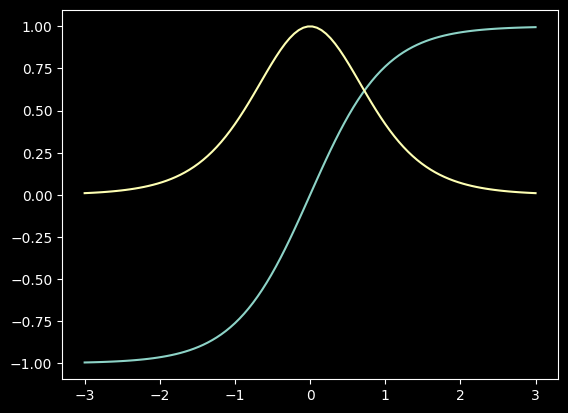

In [46]:
# function and first derivative
xrange=np.linspace(-3,3,100)
x=torch.tensor(xrange,requires_grad=True)
y=torch.tanh(x)
y.backward(torch.ones_like(x))  # backward(x) screwed up
plt.plot(xrange, y.detach().numpy())
plt.plot(xrange, x.grad.numpy())

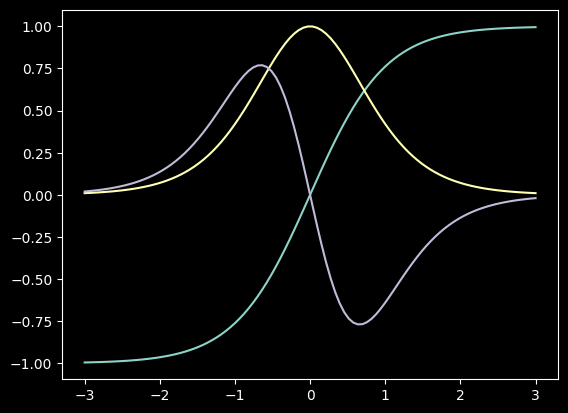

In [47]:
# function and second derivative
xrange=np.linspace(-3,3,100)
x=torch.tensor(xrange,requires_grad=True)
y=torch.tanh(x)
# output f(x), input x, grad_outputs=defines shape
# create graph for derivative calculation
ox=torch.ones_like(x)
a=torch.autograd.grad(outputs=y, inputs=x,
                      grad_outputs=ox,
                      create_graph=True)[0] # returns a 1-dim list
y.backward(ox,retain_graph=True)
plt.plot(xrange, y.detach().numpy())
plt.plot(xrange, x.grad.numpy())
x.grad.data.zero_()
a.backward(torch.ones_like(x))
plt.plot(xrange, x.grad.numpy())

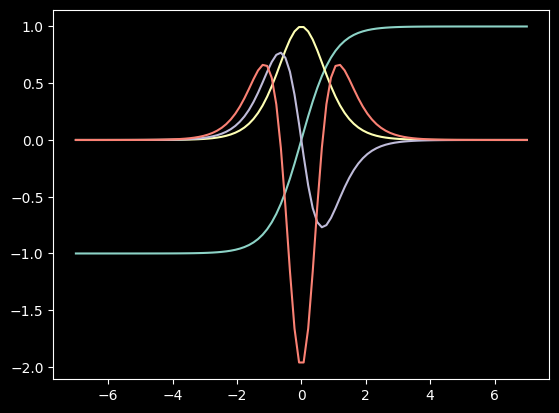

In [48]:
# function and third derivative
xrange=np.linspace(-7,7,100)
x=torch.tensor(xrange,requires_grad=True)
y=torch.tanh(x)
# output f(x), input x, grad_outputs=defines shape
# create graph for derivative calculation
ox=torch.ones_like(x) # derivative pattern
a=torch.autograd.grad(outputs=y, inputs=x,
                      grad_outputs=ox,
                      create_graph=True)[0] # returns a 1-dim list
b=torch.autograd.grad(outputs=a, inputs=x,
                      grad_outputs=ox,
                      create_graph=True)[0] # returns a 1-dim list
y.backward(ox,retain_graph=True)
plt.plot(xrange, y.detach().numpy())
plt.plot(xrange, x.grad.numpy())
x.grad.data.zero_()
a.backward(ox,retain_graph=True)
plt.plot(xrange, x.grad.numpy())
x.grad.data.zero_()
b.backward(torch.ones_like(x),retain_graph=True)
plt.plot(xrange, x.grad.numpy())

x tensor(-2., requires_grad=True) - x.grad None
y tensor(-0.9640, grad_fn=<TanhBackward0>)
--- grad ---
a
x tensor(-2., requires_grad=True) - x.grad None
--- backward ---
x tensor(-2., requires_grad=True) - x.grad tensor(0.1362)


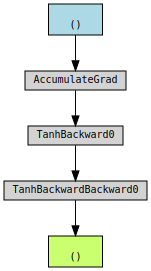

In [50]:
# torch.autograd.grad for higher derivatives
x = torch.tensor(-2., requires_grad=True)
y = torch.tanh(x)
print('x',x,'- x.grad',x.grad)
print('y',y)
print('--- grad ---')
# create graph as any other operation that can be passed by x.backward later
a=torch.autograd.grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(x),create_graph=True)[0] # 3*x**2 returns a 1-dim list
print('a')
print('x',x,'- x.grad',x.grad)
#not need x.grad.data.zero_()
print('--- backward ---')
a.backward(torch.ones_like(x)) # 2*3*x - x,grad is now second derivative
print('x',x,'- x.grad',x.grad)
make_dot(a)